In [17]:
from typing import Callable
from evaluation.eval_analysis import (
    find_shared_proofs, get_times_and_num_proofs, get_expansions_and_num_proofs, get_fine_grained_comparison_stats, get_shortest_failed_proof)
import matplotlib.pyplot as plt

In [18]:
EVAL_DIRS = [
    # -- Goal comparison mod names
    #("New GC Base", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-base"),
    #("New GC Base with Premises", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-base-premise"),
    ("New GC Fine-Tuned", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-basic"),
    ("New GC Fine-Tuned with Premises", "/home/ubuntu/coq-modeling/evals/eval/codellama-7b-premise"),

    #-- Old goal comparison
    # ("Base", "/home/ubuntu/coq-modeling/evals/eval_beam_string_comp/codellama-7b-base"),
    #("Base with Premises", "/home/ubuntu/coq-modeling/evals/eval_beam_string_comp/codellama-7b-base-premise"),
    ("Fine-Tuned", "/home/ubuntu/coq-modeling/evals/eval_beam_string_comp/codellama-7b-basic"),
    ("Fine-Tuned with Premises", "/home/ubuntu/coq-modeling/evals/eval_beam_string_comp/codellama-7b-premise"),
    

]

In [19]:
eval_dirs = [b for a, b in EVAL_DIRS]
shared_proof_names = find_shared_proofs(eval_dirs)

In [20]:
def get_matching_x_axes(
    eval_dirs: list[tuple[str, str]],
    dir_to_metric_fn: Callable[[str, set[str]], tuple[list[float], list[int]]]
) -> list[tuple[list[str], list[float], list[int]]]:
    eval_metrics: list[list[float]] = []
    eval_num_proofs: list[list[int]] = []
    eval_names: list[str] = []
    for eval_name, eval_path in eval_dirs:
        metric, num_proofs = dir_to_metric_fn(eval_path, shared_proof_names)
        eval_metrics.append(metric)
        eval_num_proofs.append(num_proofs)
        eval_names.append(eval_name)
    
    max_metric = max(map(lambda x: x[-1], eval_metrics))
    new_eval_metrics: list[list[float]] = []
    new_eval_num_proofs: list[list[int]] = []
    for metrics, num_proofs in zip(eval_metrics, eval_num_proofs):
        if metrics[-1] == max_metric:
            new_eval_metrics.append(metrics)
            new_eval_num_proofs.append(num_proofs)
        else:
            new_eval_metrics.append(metrics + [max_metric])
            new_eval_num_proofs.append(num_proofs + [num_proofs[-1]])
    return eval_names, new_eval_metrics, new_eval_num_proofs


  

Text(0.5, 1.0, '# Proofs found out of 128 Theorems.')

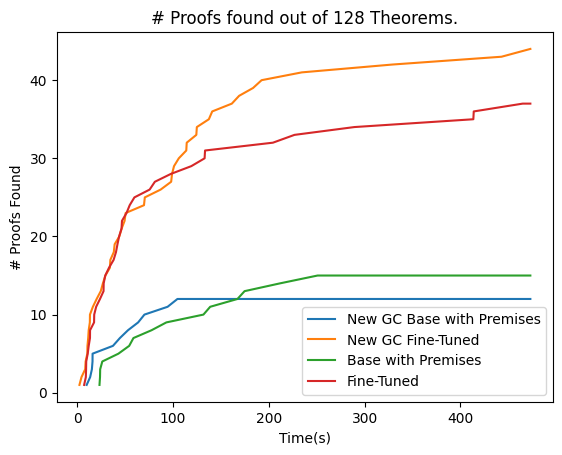

In [21]:
fig, ax = plt.subplots()
assert type(ax) == plt.Axes

eval_names, eval_times, eval_num_proofs = get_matching_x_axes(
    EVAL_DIRS, get_times_and_num_proofs
)

for eval_name, times, num_proofs in zip(eval_names, eval_times, eval_num_proofs):
    ax.plot(times, num_proofs, label=eval_name)
ax.legend()
ax.set_xlabel("Time(s)")
ax.set_ylabel("# Proofs Found")
ax.set_title(f"# Proofs found out of {len(shared_proof_names)} Theorems.")


Text(0.5, 1.0, '# Proofs Found out of 128 Theorems.')

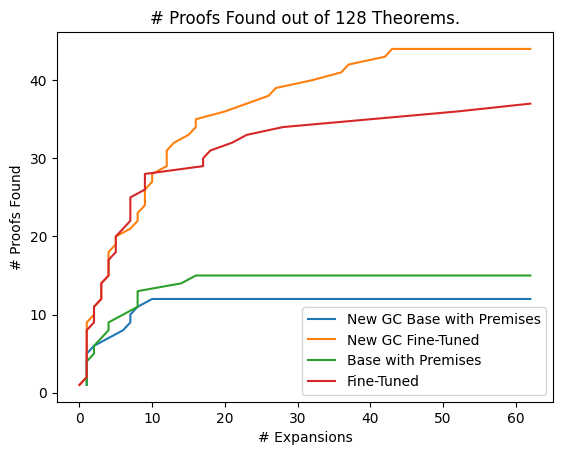

In [22]:
fig, ax = plt.subplots()
assert type(ax) == plt.Axes

eval_names, eval_expansions, eval_num_proofs = get_matching_x_axes(
    EVAL_DIRS, get_expansions_and_num_proofs 
)

for eval_name, expansions, num_proofs in zip(eval_names, eval_expansions, eval_num_proofs):
    ax.plot(expansions, num_proofs, label=eval_name)

ax.legend()
ax.set_xlabel("# Expansions")
ax.set_ylabel("# Proofs Found")
ax.set_title(f"# Proofs Found out of {len(shared_proof_names)} Theorems.")

In [23]:
get_fine_grained_comparison_stats(EVAL_DIRS, shared_proof_names)

Total Number of Theorems: 128.
Cardinality of union of all proofs found: 46
------------ New GC Base with Premises -----------------
Number of proofs found: 12
Dominated by: []
Number of unique proofs found: 0

------------ New GC Fine-Tuned -----------------
Number of proofs found: 44
Dominated by: []
Number of unique proofs found: 8

------------ Base with Premises -----------------
Number of proofs found: 15
Dominated by: []
Number of unique proofs found: 0

------------ Fine-Tuned -----------------
Number of proofs found: 37
Dominated by: []
Number of unique proofs found: 1



In [24]:
get_shortest_failed_proof(EVAL_DIRS, "/home/ubuntu/coq-modeling/failed-examples")

/home/ubuntu/coq-modeling/failed-examples exists.
